<a href="https://colab.research.google.com/github/ThiagoKoscak/PUCRJ-M2/blob/main/Olimpiadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Olimpíadas**

## Descrição
Este trabalho visa construir um pipeline que irá envolver a busca, coleta, modelagem, carga e análise dos dados sobre o dataset escolhido.

## Objetivo
Construir uma estrutura que seja capaz de responder às seguintes perguntas:
*   Ser o país sede das olimpíadas, faz com que a performance seja melhor?
*   O país sede ganha de fato vagas extras? Isso influencia diretamente no número de medalhas?
*   O número de participações femininas vem crescendo ao longo da história das Olímpiadas?
*   O número de participações femininas cresce igual para todos os países?

## Plataforma
Irei utilizar o google colab para apresentar a etapa de coleta, para que então seja feita a modelagem do DW e carga dos dados no Gogle Big Query e por fim serão feitas consultas SQL para análise e apresentação dos resultados.



#  1 - Busca pelos dados / Coleta

Optei por coletar dados do Kaggle, plataforma que já utilizei como base para coleta dos dados do módulo anterior.
Estou usando como base os dados fornecidos por este dataset:
https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results/data

Segundo a descrição desse dataset, os dados foram coletados do site www.sports-reference.com em Maio de 2018 e apresentam os dados históricos das olimpíadas de Atenas em 1896 até Rio de Janeiro em 2016.

## Dados

Os dados foram coletados do Kaggle e disponibilizados no GitHub para facilitar a interação com os dados. Os dados possuem licença CC0: Public Domain, podendo assim ser disponibilizados dessa forma.



*   **athlete_events.csv**


1. ID - Número identificador unico de cada atleta
2. Name - Nome do Atleta
3. Sex - Masculino ou Feminino (M ou F)
4. Age - Idade do atleta
5. Height - Altura do atleta em centimetros
6. Weight - Peso do atleta em quilos
7. Team - Nome do Time, sendo na grande maioria o nome do país
8. NOC - "National Olympic Committee" Código de 3 letras referente ao país
9. Games - Ano dos jogos seguido de verão ou inverno (Summer/Winter)
10. Year - Ano dos jogos
11. Season - Verão ou inverno (Summer/Winter)
12. City - Cidade que foi sede dos jogos
13. Sport - Esporte
14. Event - Descrição com mais detalhes do esporte
15. Medal - Descreve qual medalha foi ganha (Gold/Silver/Bronze), sendo NA em caso de nenhuma

*   **noc_regions.csv**

1. NOC - "National Olympic Committee" Código de 3 letras referente ao país
2. Region - Possui o nome do país, com algumas exceções
3. Notes - Alguns detalhes para os casos atípicos

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Coleta dos dados
df_bronze = pd.read_csv('https://raw.githubusercontent.com/ThiagoKoscak/PUCRJ-M2/main/athlete_events.csv')
df_noc_bronze = pd.read_csv('https://raw.githubusercontent.com/ThiagoKoscak/PUCRJ-M2/main/noc_regions.csv')

# Convertendo o csv para Parquet a fim de melhorar a leitura
df_bronze.to_parquet('athlete_events.parquet')
df_bronze = pd.read_parquet('athlete_events.parquet')

df_noc_bronze = df_noc_bronze.to_parquet('noc_regions.parquet')
df_noc_bronze = pd.read_parquet('noc_regions.parquet')

In [3]:
display(df_bronze)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,None
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",None
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",None
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,None


## 1.1 - Transformação dos dados

Nessa etapa, além dos tratamentos de dados e verificações sintáticas e semânticas, também terão algumas saídas de dados, apenas para demonstrar alguma situação ou apresentar uma linha de raciocínio.

Optei por não usar propriamente uma biblioteca de pipeline, a fim de poder mostrar as consultas e os porquês de cada decisão.

**Obs:** Nessa etapa acredito estar o equivalente ao que foi pedido no item 5.a da proposta de MVP (tratado neste projeto como item 4.1 - Qualidade de dados)

### 1.1.1 Validação de colunas numéricas

Aparentemente não há nenhuma coluna numérica com uma String, porém iremos ter um controle sobre isso ainda assim.

In [4]:
#Detalhes sobre os dados
df_bronze.describe()


,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


In [5]:
# Define a função que verifica se cada valor é do tipo numérico
def is_numeric(x):
    return isinstance(x, (int, float))

# Aplica a função a cada valor nas colunas "ID", "Age", "Height", "Weight" e "Year"
numeric_cols = ['ID', 'Age', 'Height', 'Weight', 'Year']
numeric_mask = df_bronze[numeric_cols].applymap(is_numeric)

# Remove os registros com valores de string nas colunas numéricas
df_bronze = df_bronze[numeric_mask.all(axis=1)]

### 1.1.2 - Análise de nulos
No código abaixo, podemos notar que existem muitos valores nulos em Idade, Peso e Tamanho, porém como não iremos utilizar esses dados para nenhuma análise, irei mantê-los dessa maneira.

In [6]:
# Contagem de valores nulos
null_counts = df_bronze.isnull().sum()
print(null_counts)

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64


### 1.1.3 - Remoção de duplicatas

No código abaixo, estamos encontrando dados duplicados, então estou fazendo uma rotina para remoção.

In [7]:
duplicates = df_bronze.duplicated()
duplicate_rows = df_bronze[duplicates]
duplicate_rows.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1252,704,Dsir Antoine Acket,M,27.0,NaN,NaN,Belgium,BEL,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
4282,2449,William Truman Aldrich,M,48.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Painting, Drawings And ...",None
4283,2449,William Truman Aldrich,M,48.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Painting, Drawings And ...",None
4862,2777,Hermann Reinhard Alker,M,43.0,NaN,NaN,Germany,GER,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Architecture, Designs F...",None
4864,2777,Hermann Reinhard Alker,M,43.0,NaN,NaN,Germany,GER,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Architecture, Architect...",None


In [8]:
# Obtém os índices das linhas duplicadas
duplicate_indices = duplicate_rows.index

# Remove as linhas duplicadas do dataframe original
df_bronze = df_bronze.drop(duplicate_indices)

### 1.1.4 - Verificação de Season

Não foi encontrado nenhum caso, mas ainda assim iremos utilizar essa regra.
Hoje em dia existe uma diferença de dois anos entre os jogos de verão e inverno, porém antigamente os jogos aconteciam no mesmo ano, então essa separação é importante.



In [9]:
df_bronze['Season'].value_counts()

Season
Summer    221167
Winter     48564
Name: count, dtype: int64

In [10]:
# Remove qualquer linha que não tenha "Summer" ou "Winter" na coluna "Season"
df_bronze = df_bronze.query('Season == "Summer" or Season == "Winter"')

### 1.1.5 - Verificação de Sports

Não foi encontrado nenhum caso de Sport que pareça ter seu nome errado, então não foi criado nenhum tipo de ajuste.

In [11]:
sport_count= df_bronze['Sport'].value_counts()
# Convertendo para string para poder ver todas as linhas no notebook
sport_count = sport_count.to_string()
print(sport_count)

Sport
Athletics                    38624
Gymnastics                   26707
Swimming                     23195
Shooting                     11448
Cycling                      10827
Fencing                      10735
Rowing                       10595
Cross Country Skiing          9133
Alpine Skiing                 8829
Wrestling                     7154
Football                      6745
Sailing                       6549
Equestrianism                 6343
Canoeing                      6171
Boxing                        6047
Speed Skating                 5613
Ice Hockey                    5516
Hockey                        5417
Biathlon                      4893
Basketball                    4536
Weightlifting                 3937
Water Polo                    3846
Judo                          3801
Handball                      3665
Volleyball                    3404
Bobsleigh                     3058
Tennis                        2862
Diving                        2842
Ski Jumping   

### 1.1.6 - Verificação de Ano

Não foi encontrado nenhum caso onde a data não seja entre as primeiras olimpíadas (1896) e a data atual, ainda assim criei um controle para evitar esse tipo de dado.

In [12]:
import datetime

# Obtém o ano atual
current_year = datetime.datetime.now().year

# Verifica se há algum ano inválido na coluna "Year"
any_invalid_year = ((df_bronze['Year'] < 1896) | (df_bronze['Year'] > current_year)).any()

# Imprime o resultado da verificação
print(any_invalid_year)


False


In [13]:
# Remove qualquer registro com um ano fora do intervalo entre 1896 e o ano atual
df_bronze = df_bronze.query('1896 <= Year <= @current_year')

### 1.1.7 - Verificação de NOC duplicados

Não foram encontrados, porém não criarei nenhuma regra, uma vez que caso isso ocorra, o caso deverá ser analisado a parte.


In [14]:
duplicates = df_noc_bronze.duplicated(subset=["NOC"])
duplicate_rows = df_noc_bronze[duplicates]
duplicate_rows.head()

,NOC,region,notes


### 1.1.8 Limpeza de espaços em branco das strings

In [15]:
# Remove todos os caracteres invisíveis e espaços em branco no início e no final do nome
df_bronze['Name'] = df_bronze['Name'].str.strip()
df_bronze['Sport'] = df_bronze['Sport'].str.strip()
df_bronze['Event'] = df_bronze['Event'].str.strip()

## 1.2 - Camada Silver

Após realizar as verificações iniciais, criamos a camada Silve e vamos criar a camada Gold aplicando algumas regras de negócio, fazendo a limpeza dos dados e executando a devida formatação.

In [16]:
df_silver = df_bronze.copy()
df_noc_silver = df_noc_bronze.copy()

### 1.2.1 - Criação de uma coluna de cidade no arquivo de NOC

Nesse ponto iremos criar um mapeamento manual entre cidades sede e NOCs, para poder chegar na informação de país sede.




In [17]:
cities = df_silver['City'].unique().tolist()
cities

['Barcelona',
 'London',
 'Antwerpen',
 'Paris',
 'Calgary',
 'Albertville',
 'Lillehammer',
 'Los Angeles',
 'Salt Lake City',
 'Helsinki',
 'Lake Placid',
 'Sydney',
 'Atlanta',
 'Stockholm',
 'Sochi',
 'Nagano',
 'Torino',
 'Beijing',
 'Rio de Janeiro',
 'Athina',
 'Squaw Valley',
 'Innsbruck',
 'Sarajevo',
 'Mexico City',
 'Munich',
 'Seoul',
 'Berlin',
 'Oslo',
 "Cortina d'Ampezzo",
 'Melbourne',
 'Roma',
 'Amsterdam',
 'Montreal',
 'Moskva',
 'Tokyo',
 'Vancouver',
 'Grenoble',
 'Sapporo',
 'Chamonix',
 'St. Louis',
 'Sankt Moritz',
 'Garmisch-Partenkirchen']

In [18]:
# Criação de um dicionário com a relação entre cidade e NOC, assim posso saber qual foi o país sede.
city_to_noc = {
    'Barcelona': 'ESP',
    'London': 'GBR',
    'Antwerpen': 'BEL',
    'Paris': 'FRA',
    'Calgary': 'CAN',
    'Albertville': 'FRA',
    'Lillehammer': 'NOR',
    'Los Angeles': 'USA',
    'Salt Lake City': 'USA',
    'Helsinki': 'FIN',
    'Lake Placid': 'USA',
    'Sydney': 'AUS',
    'Atlanta': 'USA',
    'Stockholm': 'SWE',
    'Sochi': 'RUS',
    'Nagano': 'JPN',
    'Torino': 'ITA',
    'Beijing': 'CHN',
    'Rio de Janeiro': 'BRA',
    'Athina': 'GRE',
    'Squaw Valley': 'USA',
    'Innsbruck': 'AUT',
    'Sarajevo': 'YUG',
    'Mexico City': 'MEX',
    'Munich': 'FRG',
    'Seoul': 'KOR',
    'Berlin': 'GER',
    'Oslo': 'NOR',
    'Cortina d\'Ampezzo': 'ITA',
    'Melbourne': 'AUS',
    'Roma': 'ITA',
    'Amsterdam': 'NED',
    'Montreal': 'CAN',
    'Moskva': 'RUS',
    'Tokyo': 'JPN',
    'Vancouver': 'CAN',
    'Grenoble': 'FRA',
    'Sapporo': 'JPN',
    'Chamonix': 'FRA',
    'St. Louis': 'USA',
    'Sankt Moritz': 'SUI',
    'Garmisch-Partenkirchen': 'GER'
}

# Adiciona a nova coluna 'City' ao dataframe df_noc_silver usando o dicionário
df_silver['NOC_Sede'] = df_silver['City'].map(city_to_noc.get)

### 1.2.2 - Verificação de regiões sem valor ou ausentes

A coluna notes num geral traz informações como nomes antigos ou nomes alternativos daquela região.
Porém nesses poucos casos em que a coluna region está com valor nulo, essa coluna notes traz uma informação melhor, então iremos utilizar ela no lugar de region nesses casos.

In [19]:
# Contagem de valores nulos
null_counts = df_noc_silver.isnull().sum()
null_counts

NOC         0
region      3
notes     209
dtype: int64

In [20]:
null_region_df = df_noc_silver[df_noc_silver['region'].isnull()]
null_region_df

,NOC,region,notes
168,ROT,None,Refugee Olympic Team
208,TUV,None,Tuvalu
213,UNK,None,Unknown


In [21]:
df_noc_silver.loc[df_noc_silver['region'].isnull(), 'region'] = df_noc_silver['notes']

In [22]:
# Adicionar os NOCs ausentes
novos_dados = pd.DataFrame({'NOC': ['SGP'], 'region': ['Singapore']})

# Concatena o novo dataframe ao dataframe original df_noc_silver
df_noc_silver = pd.concat([df_noc_silver, novos_dados], ignore_index=True)

### 1.2.3 - Divisão de medalhas

Separação da coluna Medal, em três colunas representando a contagem de medalhas de Ouro, Prata e Bronze.

In [23]:
df_silver = pd.get_dummies(df_silver, columns=['Medal'], prefix='Medal', dtype=int)

### 1.2.4 - Verificação de Time / Solo

Como essa análise é por atleta, eu tenho que levar em consideração quais esportes são individuais e quais são em time, já que por exemplo, em um time de futebol eu teria 22 medalhas.

Primeiramente cogitei fazer uma agregação por 'Team', 'NOC', 'Year', 'Season', 'City', 'Sport', 'Event','Medal_Bronze','Medal_Silver','Medal_Gold', porém há esportes que são individuais e possui diversos atletas do mesmo país.

Com isso foi criado um banco de palavras chaves que definem se o esporte é em grupo (Team), e os que não se encaixam serão do tipo individual(Solo).

Com as verificações que fiz com os dados oficiais das olimpíadas, fui capaz de gerar dados muito próximos dos reais, com algumas diferenças devido a medalhas que foram removidas posteriormente (como em casos de doping) e que esses dados não contemplam.


In [24]:
# Gera a lista de eventos únicos
events = df_silver['Event'].unique().tolist()
events

["Basketball Men's Basketball",
 "Judo Men's Extra-Lightweight",
 "Football Men's Football",
 "Tug-Of-War Men's Tug-Of-War",
 "Speed Skating Women's 500 metres",
 "Speed Skating Women's 1,000 metres",
 "Cross Country Skiing Men's 10 kilometres",
 "Cross Country Skiing Men's 50 kilometres",
 "Cross Country Skiing Men's 10/15 kilometres Pursuit",
 "Cross Country Skiing Men's 4 x 10 kilometres Relay",
 "Cross Country Skiing Men's 30 kilometres",
 "Athletics Women's 100 metres",
 "Athletics Women's 4 x 100 metres Relay",
 "Ice Hockey Men's Ice Hockey",
 "Swimming Men's 400 metres Freestyle",
 "Badminton Men's Singles",
 "Sailing Women's Windsurfer",
 "Biathlon Women's 7.5 kilometres Sprint",
 "Swimming Men's 200 metres Breaststroke",
 "Swimming Men's 400 metres Breaststroke",
 "Gymnastics Men's Individual All-Around",
 "Gymnastics Men's Team All-Around",
 "Gymnastics Men's Floor Exercise",
 "Gymnastics Men's Horse Vault",
 "Gymnastics Men's Parallel Bars",
 "Gymnastics Men's Horizontal Bar

In [25]:
# criar expressão regular para identificar eventos em time
palavras_chaves = r'\b(Relay|Team|Double|Pair|Mixed|Four|Eight|Coxed|Coxless|Synchronized|Doubles|Fours|Eights|Quadruple|Quad|Sculls|Pursuit|Keirin|Madison|Sprint|Omnium|Time Trial|Road Race|Criterium|Points Race|Elimination Race|Scratch Race|Handball|Volleyball|Basketball|Football|Hockey|Rugby|Water Polo|Ice Hockey|Beach Volleyball|Handball|Two|Group|Skiff|Curling)\b'

# adicionar coluna Event_Type ao dataframe
df_silver['Event_Type'] = 'Solo'

# preencher coluna Event_Type com "Team" para eventos em time
df_silver.loc[df_silver['Event'].str.contains(palavras_chaves, na=False), 'Event_Type'] = 'Team'


<ipython-input-25-d3e3c253c284>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_silver.loc[df_silver['Event'].str.contains(palavras_chaves, na=False), 'Event_Type'] = 'Team'


In [62]:
# # Verificações de quadro de medalhas para poder comparar com número oficiais - foi usado apenas para conferir resultados
# df_2016_gold = df_silver[(df_silver['Year'] == 2016) & (df_silver['Medal_Gold'] >= 1)].copy()
# #df_2016_gold = df_silver[(df_silver['Year'] == 2004) & (df_silver['NOC'] == 'AUS') & (df_silver['Medal_Gold'] >= 1)].copy()

# # criar a coluna Medal_Count
# df_2016_gold.loc[:, 'Medal_Count'] = np.where(df_2016_gold['Event_Type'] == 'Solo', 1, 1 / df_2016_gold.groupby(['NOC', 'Year', 'Sport', 'Event', 'Medal_Gold'])['ID'].transform('count'))

# # agrupar por NOC e contar as medalhas
# medal_counts = df_2016_gold.groupby('NOC')['Medal_Count'].sum()
# #medal_counts = df_2016_gold.groupby(['NOC','Event'])['Medal_Count'].sum()

# # exibir o resultado
# medal_counts = medal_counts.sort_values(ascending=False)
# print(medal_counts)


### 1.2.5 - Join dos dois arquivos

Como o arquivo df_noc_silver ficou com pouco conteúdo, resolvi fazer o join dois dois para facilitar o entendimento.

In [27]:
df_silver = df_silver.merge(df_noc_silver, left_on='NOC', right_on='NOC', how='inner')
df_silver = df_silver.merge(df_noc_silver, left_on='NOC_Sede', right_on='NOC', how='inner')

### 1.2.6 - Seleção das colunas que serão utilizadas

Passar a lista de colunas que queremos utilizar para análise.

In [28]:
df_silver_list = ['ID', 'Name', 'Sex', 'Age','Height','Weight','NOC_x','region_x','Year','Season','City','NOC_y','region_y','Sport','Event','Event_Type','Medal_Bronze','Medal_Silver','Medal_Gold']
df_silver = df_silver[df_silver_list]

### 1.2.7 - Renomear colunas

Trazer os nomes para portugues

In [29]:
df_silver_map = {'ID': 'id',
                  'Name': 'nome',
                  'Sex': 'sexo',
                  'Age': 'idade',
                  'Height': 'altura',
                  'Weight': 'peso',
                  'NOC_x': 'con',
                  'region_x': 'pais',
                  'Year': 'ano',
                  'Season': 'temporada',
                  'City': 'cidade_sede',
                  'NOC_y': 'con_sede',
                  'region_y': 'pais_sede',
                  'Sport': 'esporte',
                  'Event': 'esporte_detalhe',
                  'Event_Type': 'esporte_tipo',
                  'Medal_Bronze': 'bronze',
                  'Medal_Silver': 'prata',
                  'Medal_Gold': 'ouro'}

df_silver= df_silver.rename(columns=df_silver_map)
df_silver

,id,nome,sexo,idade,altura,peso,con,pais,ano,temporada,cidade_sede,con_sede,pais_sede,esporte,esporte_detalhe,esporte_tipo,bronze,prata,ouro
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,China,1992,Summer,Barcelona,ESP,Spain,Basketball,Basketball Men's Basketball,Team,0,0,0
1,6848,Bai Chongguang,M,21.0,184.0,83.0,CHN,China,1992,Summer,Barcelona,ESP,Spain,Boxing,Boxing Men's Light-Heavyweight,Solo,0,0,0
2,6854,Bai Mei,F,17.0,166.0,46.0,CHN,China,1992,Summer,Barcelona,ESP,Spain,Rhythmic Gymnastics,Rhythmic Gymnastics Women's Individual,Solo,0,0,0
3,11225,Bi Zhong,M,23.0,188.0,110.0,CHN,China,1992,Summer,Barcelona,ESP,Spain,Athletics,Athletics Men's Hammer Throw,Solo,0,0,0
4,17295,Cai Yanshu,M,28.0,169.0,79.0,CHN,China,1992,Summer,Barcelona,ESP,Spain,Weightlifting,Weightlifting Men's Light-Heavyweight,Solo,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269726,106528,Leopold Schdler,M,21.0,NaN,NaN,LIE,Liechtenstein,1948,Winter,Sankt Moritz,SUI,Switzerland,Alpine Skiing,Alpine Skiing Men's Downhill,Solo,0,0,0
269727,106528,Leopold Schdler,M,21.0,NaN,NaN,LIE,Liechtenstein,1948,Winter,Sankt Moritz,SUI,Switzerland,Alpine Skiing,Alpine Skiing Men's Combined,Solo,0,0,0
269728,108435,Theodor Sele,M,16.0,NaN,NaN,LIE,Liechtenstein,1948,Winter,Sankt Moritz,SUI,Switzerland,Alpine Skiing,Alpine Skiing Men's Downhill,Solo,0,0,0
269729,108435,Theodor Sele,M,16.0,NaN,NaN,LIE,Liechtenstein,1948,Winter,Sankt Moritz,SUI,Switzerland,Alpine Skiing,Alpine Skiing Men's Combined,Solo,0,0,0


In [30]:
df_silver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269731 entries, 0 to 269730
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               269731 non-null  int64  
 1   nome             269731 non-null  object 
 2   sexo             269731 non-null  object 
 3   idade            260416 non-null  float64
 4   altura           210917 non-null  float64
 5   peso             208204 non-null  float64
 6   con              269731 non-null  object 
 7   pais             269731 non-null  object 
 8   ano              269731 non-null  int64  
 9   temporada        269731 non-null  object 
 10  cidade_sede      269731 non-null  object 
 11  con_sede         269731 non-null  object 
 12  pais_sede        269731 non-null  object 
 13  esporte          269731 non-null  object 
 14  esporte_detalhe  269731 non-null  object 
 15  esporte_tipo     269731 non-null  object 
 16  bronze           269731 non-null  int6

## 1.3 - Camada Gold
Com isso criamos a camada gold

In [31]:
df_gold = df_silver.copy()

df_gold.to_parquet('df_gold.parquet')

## 1.4 - Catálogo de dados

**Nome do conjunto de dados**: Olimpíadas

**Descrição**: Este conjunto de dados contém informações sobre os atletas que ganharam medalhas nas Olimpíadas de Verão e Inverno, incluindo o nome do atleta, sexo, idade, altura, peso, comitê olímpico nacional (CON), ano, temporada, cidade sede, esporte, detalhes do esporte, medalha de bronze, medalha de prata e medalha de ouro.

Colunas de df_gold:

* **id**: Identificador único do atleta.
<br>Tipo: Inteiro
<br>Característica: Não deve ser nulo e deve ser único

* **nome**: Nome completo do atleta.
<br>Tipo: Texto
<br>Característica: Não deve ser nulo

* **sexo**: Sexo do atleta M ou F (Masculino ou Feminino).
<br>Tipo: Texto
<br>Característica: Não deve ser nulo

* **idade**: Idade do atleta em anos.
<br>Tipo: Inteiro
<br>Característica: Pode ser nulo

* **altura**: Altura do atleta em centímetros.
<br>Tipo: Float
<br>Característica: Pode ser nulo

* **peso**: Peso do atleta em quilogramas.
<br>Tipo: Float
<br>Característica: Pode ser nulo

* **con**: Código de três letras do Comitê Olímpico Nacional do atleta.
<br>Tipo: Texto
<br>Característica: Não deve ser nulo e deve ser único

* **pais**: Nome do país pelo qual o atleta está competindo.
<br>Tipo: Texto
<br>Característica: Não deve ser nulo

* **ano**: Ano dos Jogos Olímpicos.
<br>Tipo: Inteiro
<br>Característica: Não deve ser nulo

* **temporada**: Temporada dos Jogos Olímpicos Verão ou Inverno (Summer ou Winter).
<br>Tipo: Texto
<br>Característica: Não deve ser nulo

* **cidade_sede**: Cidade sede dos Jogos Olímpicos.
<br>Tipo: Texto
<br>Característica: Não deve ser nulo

* **con_sede**: Código de três letras do Comitê Olímpico Nacional do atleta do país sede.
<br>Tipo: Texto
<br>Característica: Não deve ser nulo e deve ser único

* **pais_sede**: Nome do país sede.
<br>Tipo: Texto
<br>Característica: Não deve ser nulo

* **esporte**: Esporte praticado pelo atleta.
<br>Tipo: Texto
<br>Característica: Não deve ser nulo

* **esporte_detalhe**: Detalhes do evento do esporte praticado pelo atleta.
<br>Tipo: Texto
<br>Característica: Pode ser nulo

* **esporte_tipo**: Descreve se o esporte é individual ou em time (Solo ou Team).
<br>Tipo: Texto
<br>Característica: Não deve ser nulo

* **bronze**: Número de medalhas de bronze conquistadas pelo atleta.
<br>Tipo: Inteiro
<br>Característica: Não deve ser negativo

* **prata**: Número de medalhas de prata conquistadas pelo atleta.
<br>Tipo: Inteiro
<br>Característica: Não deve ser negativo

* **ouro**: Número de medalhas de ouro conquistadas pelo atleta.
<br>Tipo: Inteiro
<br>Característica: Não deve ser negativo

# 2 - Modelagem

Nessa etapa eu acesso minha conta no GCP para acessar meu projeto no BigQuery.

In [32]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
from google.api_core.exceptions import NotFound
import pandas_gbq

In [33]:
project_id = 'pucrio-428615'
client = bigquery.Client(project=project_id)

## 2.1 - Criação do Dataset

In [34]:
# # Definir o ID do dataset
# dataset_id = "Olimpiadas"

# # Criar o dataset
# dataset = client.dataset(dataset_id, project=project_id)
# client.create_dataset(dataset)

## 2.2 - Criação das Dimensões

Antes de iniciar a carga de dados, eu recrio as tabelas do modelo utilizando a cláusula "replace" no processo de carga, o que resulta na perda das chaves primárias (PKs) e estrangeiras (FKs) previamente criadas. Dessa forma, optei por utilizar a cláusula "append" para adicionar os dados às tabelas já existentes, uma vez que meu processo de ETL não contempla a atualização de dados, apenas uma carga única de todos os dados. Por esse motivo, realizei um delete inicial das tabelas para garantir a integridade dos dados.

In [35]:
### Delete de todas as tabelas
table_ref = client.dataset('Olimpiadas').table('dim_edicao')
client.delete_table(table_ref)

table_ref = client.dataset('Olimpiadas').table('dim_atleta')
client.delete_table(table_ref)

table_ref = client.dataset('Olimpiadas').table('dim_participacao')
client.delete_table(table_ref)

table_ref = client.dataset('Olimpiadas').table('dim_esporte')
client.delete_table(table_ref)

table_ref = client.dataset('Olimpiadas').table('dim_pais')
client.delete_table(table_ref)

table_ref = client.dataset('Olimpiadas').table('fato_medalhas')
client.delete_table(table_ref)

###  2.2.1 - dim_edicao

In [36]:
query = """
CREATE TABLE `Olimpiadas.dim_edicao` (
  dim_edicao_id INT64 NOT NULL,
  ano INT64 NOT NULL,
  temporada STRING NOT NULL,
  cidade_sede STRING NOT NULL,
  con_sede STRING NOT NULL,
  pais_sede STRING NOT NULL,
  PRIMARY KEY (dim_edicao_id) NOT ENFORCED
)
"""

query_job = client.query(query)
query_job.result()

###  2.2.2 - dim_atleta

In [37]:
query = """
CREATE TABLE `Olimpiadas.dim_atleta` (
  dim_atleta_id INT64 NOT NULL,
  nome STRING NOT NULL,
  sexo STRING NOT NULL,
  PRIMARY KEY (dim_atleta_id) NOT ENFORCED
)
"""

query_job = client.query(query)
query_job.result()

### 2.2.3 - dim_participacao

In [38]:
query = """
CREATE TABLE `Olimpiadas.dim_participacao` (
  dim_participacao_id INT64 NOT NULL,
  dim_atleta_id INT64 NOT NULL,
  dim_edicao_id INT64 NOT NULL,
  idade INT64,
  peso FLOAT64,
  altura FLOAT64,
  con STRING NOT NULL,
  pais STRING NOT NULL,
  PRIMARY KEY (dim_participacao_id) NOT ENFORCED,
  FOREIGN KEY (dim_atleta_id) REFERENCES `Olimpiadas.dim_atleta` (dim_atleta_id) NOT ENFORCED,
  FOREIGN KEY (dim_edicao_id) REFERENCES `Olimpiadas.dim_edicao` (dim_edicao_id) NOT ENFORCED
)
"""

query_job = client.query(query)
query_job.result()

### 2.2.4 - dim_esporte

In [39]:
query = """
CREATE TABLE `Olimpiadas.dim_esporte` (
  dim_esporte_id INT64 NOT NULL,
  esporte STRING NOT NULL,
  esporte_detalhe STRING NOT NULL,
  esporte_tipo STRING NOT NULL,
  PRIMARY KEY (dim_esporte_id) NOT ENFORCED
)
"""

query_job = client.query(query)
query_job.result()

### 2.2.5 - dim_pais

In [40]:
query = """
CREATE TABLE `Olimpiadas.dim_pais` (
  dim_pais_id INT64 NOT NULL,
  con STRING NOT NULL,
  pais STRING NOT NULL,
  PRIMARY KEY (dim_pais_id) NOT ENFORCED
)
"""

query_job = client.query(query)
query_job.result()

## 2.3 - Criação da Fato

### 2.3.1 - fato_medalhas

In [41]:
query = """
CREATE TABLE `Olimpiadas.fato_medalhas` (
  fato_medalhas_id INT64 NOT NULL,
  dim_edicao_id INT64 NOT NULL,
  dim_pais_id INT64 NOT NULL,
  dim_atleta_id INT64 NOT NULL,
  dim_participacao_id INT64 NOT NULL,
  dim_esporte_id INT64 NOT NULL,
  bronze INT64 NOT NULL,
  prata INT64 NOT NULL,
  ouro INT64 NOT NULL,
  PRIMARY KEY (fato_medalhas_id) NOT ENFORCED,
  FOREIGN KEY (dim_edicao_id) REFERENCES `Olimpiadas.dim_edicao` (dim_edicao_id) NOT ENFORCED,
  FOREIGN KEY (dim_pais_id) REFERENCES `Olimpiadas.dim_pais` (dim_pais_id) NOT ENFORCED,
  FOREIGN KEY (dim_atleta_id) REFERENCES `Olimpiadas.dim_atleta` (dim_atleta_id) NOT ENFORCED,
  FOREIGN KEY (dim_participacao_id) REFERENCES `Olimpiadas.dim_participacao` (dim_participacao_id) NOT ENFORCED,
  FOREIGN KEY (dim_esporte_id) REFERENCES `Olimpiadas.dim_esporte` (dim_esporte_id) NOT ENFORCED
)
"""

query_job = client.query(query)
query_job.result()


## 2.4 Diagrama ER
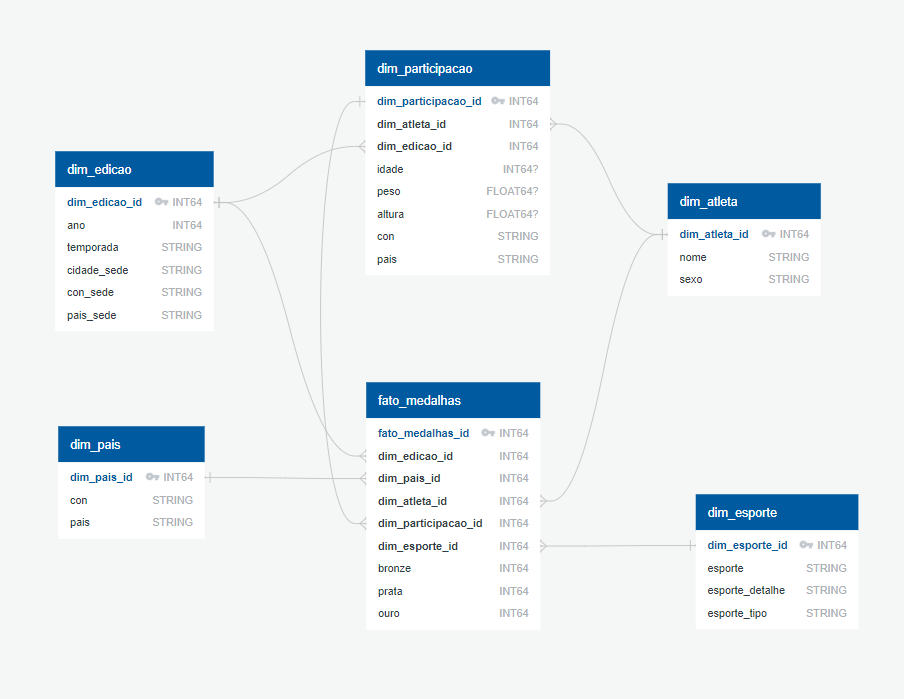

# 3 - Carga

In [42]:
# !pip install pandasql
# from pandasql import sqldf

## 3.1 - dim_edicao



In [43]:
# Gera os dados da dimensão edição
dim_edicao = df_gold[['ano','temporada','cidade_sede','con_sede','pais_sede']].drop_duplicates()
dim_edicao = dim_edicao.sort_values(by=['ano', 'temporada']).reset_index(drop=True)
dim_edicao['dim_edicao_id'] = dim_edicao.index + 1

# Insere os dados na tabela do BigQuery
table_name = 'Olimpiadas.dim_edicao'
pandas_gbq.to_gbq(dim_edicao, destination_table=table_name, project_id=project_id, if_exists='append')

100%|██████████| 1/1 [00:00<00:00, 779.90it/s]


## 3.2 - dim_atleta

In [44]:
# Gera os dados da dimensão atleta
dim_atleta = df_gold[['id','nome','sexo']].drop_duplicates()
dim_atleta = dim_atleta.rename(columns={'id': 'dim_atleta_id'})

# Insere os dados na tabela do BigQuery
table_name = 'Olimpiadas.dim_atleta'
pandas_gbq.to_gbq(dim_atleta, destination_table=table_name, project_id=project_id, if_exists='append')

100%|██████████| 1/1 [00:00<00:00, 920.21it/s]


## 3.3 - dim_participacao


In [45]:
# Gera os dados da dimensão participação
dim_participacao = df_gold[['id','idade','peso','altura','con','pais','ano','temporada','cidade_sede','con_sede','pais_sede']].drop_duplicates()
dim_participacao = dim_participacao.merge(dim_edicao, left_on=['ano','temporada','cidade_sede','con_sede','pais_sede'], right_on=['ano','temporada','cidade_sede','con_sede','pais_sede'], how='inner')
dim_participacao = dim_participacao.sort_values(by=['id']).reset_index(drop=True)
dim_participacao['dim_participacao_id'] = dim_participacao.index + 1
dim_participacao = dim_participacao.rename(columns={'id': 'dim_atleta_id'})
dim_participacao_list = ['dim_participacao_id','dim_atleta_id','dim_edicao_id','idade','peso','altura','con','pais']
dim_participacao = dim_participacao[dim_participacao_list]

# Insere os dados na tabela do BigQuery
table_name = 'Olimpiadas.dim_participacao'
pandas_gbq.to_gbq(dim_participacao, destination_table=table_name, project_id=project_id, if_exists='append')

100%|██████████| 1/1 [00:00<00:00, 8338.58it/s]


## 3.4 - dim_esporte

In [46]:
# Gera os dados da dimensão esporte
dim_esporte = df_gold[['esporte','esporte_detalhe','esporte_tipo']].drop_duplicates()
dim_esporte = dim_esporte.sort_values(by=['esporte', 'esporte_detalhe']).reset_index(drop=True)
dim_esporte['dim_esporte_id'] = dim_esporte.index + 1

# Insere os dados na tabela do BigQuery
table_name = 'Olimpiadas.dim_esporte'
pandas_gbq.to_gbq(dim_esporte, destination_table=table_name, project_id=project_id, if_exists='append')

100%|██████████| 1/1 [00:00<00:00, 4084.04it/s]


## 3.5 - dim_pais

In [47]:
# Gera os dados da dimensão país
dim_pais = df_gold[['con','pais']].drop_duplicates()
dim_pais = dim_pais.sort_values(by=['con', 'pais']).reset_index(drop=True)
dim_pais['dim_pais_id'] = dim_pais.index + 1

# Insere os dados na tabela do BigQuery
table_name = 'Olimpiadas.dim_pais'
pandas_gbq.to_gbq(dim_pais, destination_table=table_name, project_id=project_id, if_exists='append')

100%|██████████| 1/1 [00:00<00:00, 502.85it/s]


## 3.6 - fato_medalhas

In [48]:
# Gera os dados da fato medalhas
fato_medalhas = df_gold.merge(dim_edicao, left_on=['ano','temporada','cidade_sede','con_sede','pais_sede'], right_on=['ano','temporada','cidade_sede','con_sede','pais_sede'], how='inner')
fato_medalhas = fato_medalhas.merge(dim_pais, left_on=['con','pais'], right_on=['con','pais'], how='inner')
fato_medalhas = fato_medalhas.merge(dim_participacao, left_on=['id','dim_edicao_id','idade','peso','altura','con','pais'], right_on = ['dim_atleta_id','dim_edicao_id','idade','peso','altura','con','pais'])
fato_medalhas = fato_medalhas.merge(dim_esporte, left_on=['esporte','esporte_detalhe','esporte_tipo'], right_on=['esporte','esporte_detalhe','esporte_tipo'], how='inner')
fato_medalhas = fato_medalhas.sort_values(by=['ano', 'temporada']).reset_index(drop=True)
fato_medalhas['fato_medalhas_id'] = fato_medalhas.index + 1
fato_medalhas_list = ['fato_medalhas_id','dim_edicao_id','dim_pais_id','dim_atleta_id','dim_participacao_id','dim_esporte_id','bronze','prata','ouro']
fato_medalhas = fato_medalhas[fato_medalhas_list]

# Insere os dados na tabela do BigQuery
table_name = 'Olimpiadas.fato_medalhas'
pandas_gbq.to_gbq(fato_medalhas, destination_table=table_name, project_id=project_id, if_exists='append')


100%|██████████| 1/1 [00:00<00:00, 8559.80it/s]


# 4 - Análise

In [49]:
# import para gráficos
from matplotlib import pyplot as plt

## 4.1 - Qualidade de dados
Toda a etapa realizada nos itens 1.1 e 1.2 foi visando melhorar a qualidade dos dados e todos os problemas que foram encontrados nos caminhos para encontrar a solução, já foram tratados nessas etapas.

## 4.2 Solução do problema



### 4.2.1 - Ser o país sede das olimpíadas, faz com que a performance seja melhor?

Nesta análise, irei calcular a média de medalhas (ouro, prata e bronze) conquistadas pelos países quando sediaram as Olimpíadas e comparar com a média de medalhas conquistadas nas edições em que não foram sedes. A partir disso, pretendo verificar se há uma melhora significativa na performance dos países quando sediaram as Olimpíadas.


#### 4.2.1.1 - Query 1

In [50]:
# Define a consulta SQL
query = """
WITH medalhas_por_pais_e_edicao AS (
-- Detalhes de cada participação de cada país
SELECT de.dim_edicao_id, fm.dim_pais_id, dp.con, dp.pais,
       CASE WHEN dp.con = de.con_sede THEN 1 ELSE 0 END foi_sede,
       round(SUM(CASE WHEN es.esporte_tipo = 'Solo' THEN bronze ELSE (bronze / COALESCE(part.qtd_participantes,1)) END)) AS bronze,
       round(SUM(CASE WHEN es.esporte_tipo = 'Solo' THEN prata ELSE (prata / COALESCE(part.qtd_participantes,1)) END)) AS prata,
       round(SUM(CASE WHEN es.esporte_tipo = 'Solo' THEN ouro ELSE (ouro / COALESCE(part.qtd_participantes,1)) END)) AS ouro
FROM `Olimpiadas.fato_medalhas` fm
JOIN `Olimpiadas.dim_pais` dp ON dp.dim_pais_id = fm.dim_pais_id
JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
JOIN `Olimpiadas.dim_esporte` es ON es.dim_esporte_id = fm.dim_esporte_id
JOIN (
  SELECT fm.dim_edicao_id, dim_esporte_id,fm.dim_pais_id , COUNT(Distinct fm.dim_participacao_id) as qtd_participantes
  FROM `Olimpiadas.fato_medalhas` fm
  JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
  JOIN `Olimpiadas.dim_pais` dp ON dp.dim_pais_id = fm.dim_pais_id
  GROUP BY fm.dim_edicao_id, dim_esporte_id, fm.dim_pais_id
) part ON part.dim_esporte_id = es.dim_esporte_id and part.dim_edicao_id = de.dim_edicao_id and part.dim_pais_id = dp.dim_pais_id
GROUP BY de.dim_edicao_id, fm.dim_pais_id, dp.con, dp.pais, foi_sede
),
-- Detalhes de cada participação de cada país
participacoes_por_pais AS (
SELECT
    dp.con,
    dp.pais,
    COUNT(distinct de.dim_edicao_id) AS num_participacoes,
    COUNT(DISTINCT CASE WHEN dp.con = de.con_sede THEN de.dim_edicao_id END) as qtd_vezes_sede,
    COUNT(DISTINCT CASE WHEN dp.con <> de.con_sede THEN de.dim_edicao_id END) as qtd_vezes_nao_sede,
    SUM(CASE WHEN dp.con = de.con_sede THEN 1 ELSE 0 END) as qtd_atletas_sede,
    SUM(CASE WHEN dp.con <> de.con_sede THEN 1 ELSE 0 END) as qtd_atletas_nao_sede
FROM `Olimpiadas.dim_participacao` dp
JOIN `Olimpiadas.dim_edicao` de on dp.dim_edicao_id = de.dim_edicao_id
GROUP BY dp.con, dp.pais
)
SELECT
  mpe.con, mpe.pais, total_medalhas_sede, total_medalhas_nao_sede, qtd_vezes_sede, qtd_vezes_nao_sede,
  round((total_medalhas_sede/qtd_vezes_sede),2) media_sede,
  round((total_medalhas_nao_sede/qtd_vezes_nao_sede),2) media_nao_sede,
  round(((total_medalhas_sede/qtd_vezes_sede) / (total_medalhas_nao_sede/qtd_vezes_nao_sede)) * 100,2) - 100  as percentual_performance
FROM (
  SELECT
    mpe.con, mpe.pais, sum(bronze+prata+ouro) as total_medalhas_sede,
  FROM medalhas_por_pais_e_edicao mpe
  WHERE mpe.foi_sede = 1
  GROUP BY mpe.con, mpe.pais
) AS mpe
JOIN (
  SELECT
    mpe.con, mpe.pais, sum(bronze+prata+ouro) as total_medalhas_nao_sede,
  FROM medalhas_por_pais_e_edicao mpe
  WHERE mpe.foi_sede = 0
  GROUP BY mpe.con, mpe.pais
) AS mpe2 ON mpe.con = mpe2.con
JOIN participacoes_por_pais ppp ON mpe.con = ppp.con
order by percentual_performance desc
"""

# Executa a consulta e armazena os resultados em um dataframe
df = client.query(query).to_dataframe()

# Exibe os dados do dataframe
df

,con,pais,total_medalhas_sede,total_medalhas_nao_sede,qtd_vezes_sede,qtd_vezes_nao_sede,media_sede,media_nao_sede,percentual_performance
0,GRE,Greece,142.0,58.0,3,44,47.33,1.32,3490.80
1,BEL,Belgium,46.0,116.0,1,47,46.00,2.47,1763.79
2,ESP,Spain,22.0,131.0,1,41,22.00,3.20,588.55
3,GBR,UK,245.0,686.0,3,49,81.67,14.00,483.33
4,BRA,Brazil,18.0,104.0,1,30,18.00,3.47,419.23
5,AUS,Australia,104.0,486.0,2,45,52.00,10.80,381.48
6,MEX,Mexico,9.0,62.0,1,30,9.00,2.07,335.48
7,CHN,China,95.0,483.0,1,22,95.00,21.95,332.71
8,KOR,South Korea,33.0,319.0,1,33,33.00,9.67,241.38
9,SWE,Sweden,68.0,575.0,2,49,34.00,11.73,189.74


#### 4.2.1.2 - Conclusão

**Explicação dos dados**

* con e pais: mostram os dados dos países que já sediaram as Olimpíadas pelo menos uma vez na história.
* total_medalhas_sede e total_medalhas_nao_sede: mostram a soma total de medalhas (ouro, prata e bronze) conquistadas por cada país nas edições em que foi sede e nas edições em que não foi sede, respectivamente.
* qtd_vezes_sede e qtd_vezes_nao_sede: mostram a quantidade de vezes que cada país sediou as Olimpíadas e a quantidade de vezes que participou sem ser o país sede, respectivamente.
* media_sede e media_nao_sede: mostram a média de medalhas conquistadas por cada país das vezes em que foi sede e que não foi sede, respectivamente.
* percentual_performance: mostra a porcentagem de melhoria na performance de cada país nas edições em que foi sede em relação às edições em que não foi sede.

**Conclusão**

A análise dos dados mostra que há uma melhora significativa na performance dos países quando sediaram as Olimpíadas. No entanto, acredito que isso não seja apenas pelo fato de "estarem jogando em casa". Pesquisas indicam que os países sede ganham um número relativamente maior de vagas para as competições, aumentando assim suas chances de conquistar medalhas.
<br>Isso nos leva à próxima pergunta:

### 4.2.2 - O país sede ganha de fato vagas extras? Isso influencia diretamente no número de medalhas?

Aqui iremos confirmar essa teoria de que o país sede ganha um número maior de vagas, e verificar se isso pode ser o que impulsiona as altas de performances que vimos no item anterior



#### 4.2.2.1 - Query 1


In [51]:
# Define a consulta SQL
query = """WITH medalhas_por_pais_e_edicao AS (
-- Detalhes de cada participação de cada país
SELECT de.dim_edicao_id, fm.dim_pais_id, dp.con, dp.pais,
       CASE WHEN dp.con = de.con_sede THEN 1 ELSE 0 END foi_sede,
       round(SUM(CASE WHEN es.esporte_tipo = 'Solo' THEN bronze ELSE (bronze / COALESCE(part.qtd_participantes,1)) END)) AS bronze,
       round(SUM(CASE WHEN es.esporte_tipo = 'Solo' THEN prata ELSE (prata / COALESCE(part.qtd_participantes,1)) END)) AS prata,
       round(SUM(CASE WHEN es.esporte_tipo = 'Solo' THEN ouro ELSE (ouro / COALESCE(part.qtd_participantes,1)) END)) AS ouro
FROM `Olimpiadas.fato_medalhas` fm
JOIN `Olimpiadas.dim_pais` dp ON dp.dim_pais_id = fm.dim_pais_id
JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
JOIN `Olimpiadas.dim_esporte` es ON es.dim_esporte_id = fm.dim_esporte_id
JOIN (
  SELECT fm.dim_edicao_id, dim_esporte_id,fm.dim_pais_id , COUNT(Distinct fm.dim_participacao_id) as qtd_participantes
  FROM `Olimpiadas.fato_medalhas` fm
  JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
  JOIN `Olimpiadas.dim_pais` dp ON dp.dim_pais_id = fm.dim_pais_id
  GROUP BY fm.dim_edicao_id, dim_esporte_id, fm.dim_pais_id
) part ON part.dim_esporte_id = es.dim_esporte_id and part.dim_edicao_id = de.dim_edicao_id and part.dim_pais_id = dp.dim_pais_id
GROUP BY de.dim_edicao_id, fm.dim_pais_id, dp.con, dp.pais, foi_sede
),
-- Detalhes de cada participação de cada país
participacoes_por_pais AS (
SELECT
    dp.con,
    dp.pais,
    COUNT(distinct de.dim_edicao_id) AS num_participacoes,
    COUNT(DISTINCT CASE WHEN dp.con = de.con_sede THEN de.dim_edicao_id END) as qtd_vezes_sede,
    COUNT(DISTINCT CASE WHEN dp.con <> de.con_sede THEN de.dim_edicao_id END) as qtd_vezes_nao_sede,
    SUM(CASE WHEN dp.con = de.con_sede THEN 1 ELSE 0 END) as qtd_atletas_sede,
    SUM(CASE WHEN dp.con <> de.con_sede THEN 1 ELSE 0 END) as qtd_atletas_nao_sede
FROM `Olimpiadas.dim_participacao` dp
JOIN `Olimpiadas.dim_edicao` de on dp.dim_edicao_id = de.dim_edicao_id
GROUP BY dp.con, dp.pais
)
SELECT
  mpe.con, mpe.pais,
  round((total_medalhas_sede/qtd_vezes_sede),2) media_sede,
  round((total_medalhas_nao_sede/qtd_vezes_nao_sede),2) media_nao_sede,
  round(((total_medalhas_sede/qtd_vezes_sede) / (total_medalhas_nao_sede/qtd_vezes_nao_sede)) * 100,2) - 100  as percentual_performance,
  round((qtd_atletas_sede/qtd_vezes_sede),0) media_qtd_atletas_sede,
  round((qtd_atletas_nao_sede/qtd_vezes_nao_sede),0) media_qtd_atletas_nao_sede,
  round(((qtd_atletas_sede/qtd_vezes_sede) / (qtd_atletas_nao_sede/qtd_vezes_nao_sede)) * 100,2) - 100  as percentual_qtd_atletas,
FROM (
  SELECT
    mpe.con, mpe.pais, sum(bronze+prata+ouro) as total_medalhas_sede,
  FROM medalhas_por_pais_e_edicao mpe
  WHERE mpe.foi_sede = 1
  GROUP BY mpe.con, mpe.pais
) AS mpe
JOIN (
  SELECT
    mpe.con, mpe.pais, sum(bronze+prata+ouro) as total_medalhas_nao_sede,
  FROM medalhas_por_pais_e_edicao mpe
  WHERE mpe.foi_sede = 0
  GROUP BY mpe.con, mpe.pais
) AS mpe2 ON mpe.con = mpe2.con
JOIN participacoes_por_pais ppp ON mpe.con = ppp.con
order by percentual_performance desc
"""

# Executa a consulta e armazena os resultados em um dataframe
df = client.query(query).to_dataframe()

# Exibe os dados do dataframe
df

,con,pais,media_sede,media_nao_sede,percentual_performance,media_qtd_atletas_sede,media_qtd_atletas_nao_sede,percentual_qtd_atletas
0,GRE,Greece,47.33,1.32,3490.80,280.0,34.0,733.00
1,BEL,Belgium,46.00,2.47,1763.79,336.0,51.0,558.00
2,ESP,Spain,22.00,3.20,588.55,422.0,84.0,400.93
3,GBR,UK,81.67,14.00,483.33,557.0,139.0,300.55
4,BRA,Brazil,18.00,3.47,419.23,462.0,86.0,440.14
5,AUS,Australia,52.00,10.80,381.48,456.0,102.0,348.72
6,MEX,Mexico,9.00,2.07,335.48,275.0,58.0,378.26
7,CHN,China,95.00,21.95,332.71,599.0,137.0,338.10
8,KOR,South Korea,33.00,9.67,241.38,401.0,84.0,377.21
9,SWE,Sweden,34.00,11.73,189.74,227.0,101.0,123.58


#### 4.2.2.2 - Gráfico 1


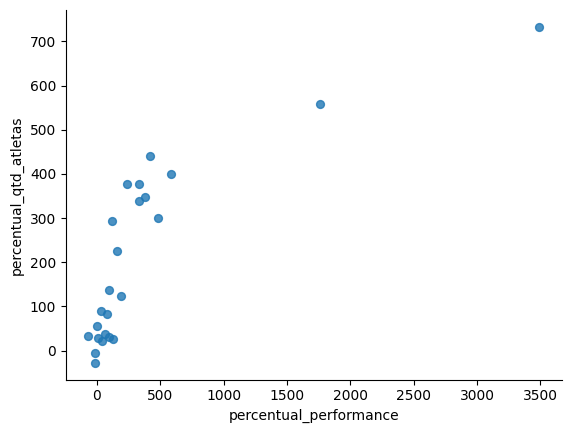

In [52]:
df.plot(kind='scatter', x='percentual_performance', y='percentual_qtd_atletas', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### 4.2.2.3 - Conclusão

**Explicação dos dados**
<br>Removi algumas colunas da análise anterior que serviam apenas para visualização e trouxe a mais os dados sobre atletas.

* con e pais: mostram os dados dos países que já sediaram as Olimpíadas pelo uma vez na história.
* media_sede e media_nao_sede: mostram a média de medalhas conquistadas por cada país das vezes em que foi sede e que não foi sede, respectivamente.
* percentual_performance: mostra a porcentagem de melhoria na performance de cada país nas edições em que foi sede em relação às edições em que não foi sede.
* media_qtd_atletas_sede e media_qtd_atletas_nao_sede: mostram a média de atletas de cada país das vezes em que foi sede e que não foi sede, respectivamente.
* percentual_qtd_atletas: mostra a porcentagem relação entre a da quantidade de atletas das vezes que foi sede e das vezes que não foi.

**Conclusão**

A análise dos dados confirmou nossa suspeita inicial de que o país sede tem um número significativamente maior de atletas participando das Olimpíadas. Além disso, observamos que nos casos da Rússia e da Suíça, que apresentaram pior desempenho nas edições em que foram sede, também houve uma queda na quantidade de atletas, o que sugere que a quantidade de atletas tem um impacto maior na quantidade de medalhas conquistadas do que o fato de ser a sede em si. O gráfico acima ilustra a forte correlação entre esses dois fatores, reforçando nossa conclusão.
<br>Embora outros fatores possam influenciar nos resultados, como a força dos países em competições de verão ou inverno, a variação na quantidade de atletas de acordo com a temporada dos jogos e a força dos países em esportes coletivos, acredito que, de forma geral, as perguntas propostas nos itens 4.2.1 e 4.2.2 foram respondidas.



### 4.2.3 - O número de participações femininas vem crescendo ao longo da história das Olímpiadas?

Nesta análise, considerarei apenas os dados referentes às Olimpíadas de Verão, uma vez que a quantidade de atletas nas Olimpíadas de Inverno é significativamente menor e dificultaria a análise. Ao focar apenas nas Olimpíadas de Verão, é possível obter uma visão mais clara e precisa da evolução da participação de homens e mulheres ao longo das edições.

#### 4.2.3.1 - Query 1

In [53]:
# Define a consulta SQL
query = """select de.ano, de.con_sede, de.pais_sede,
count(fm.dim_atleta_id) qtd_mulheres,
round((count(fm.dim_atleta_id) - LAG(count(fm.dim_atleta_id)) OVER (ORDER BY ano)) / LAG(count(fm.dim_atleta_id)) OVER (ORDER BY ano) * 100,2) AS percentual_mudanca,
round((count(fm.dim_atleta_id) - FIRST_VALUE(count(fm.dim_atleta_id)) OVER (ORDER BY ano)) / FIRST_VALUE(count(fm.dim_atleta_id)) OVER (ORDER BY ano)* 100,2)  AS percentual_em_relacao_ao_primeiro
FROM `Olimpiadas.fato_medalhas` fm
JOIN `Olimpiadas.dim_atleta` da ON da.dim_atleta_id = fm.dim_atleta_id
JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
where da.sexo = 'F' and de.temporada = 'Summer'
group by de.ano, de.con_sede, de.pais_sede
order by de.ano
"""

# Executa a consulta e armazena os resultados em um dataframe
df = client.query(query).to_dataframe()

# Exibe os dados do dataframe
df

,ano,con_sede,pais_sede,qtd_mulheres,percentual_mudanca,percentual_em_relacao_ao_primeiro
0,1900,FRA,France,33,NaN,0.00
1,1904,USA,USA,16,-51.52,-51.52
2,1906,GRE,Greece,11,-31.25,-66.67
3,1908,GBR,UK,47,327.27,42.42
4,1912,SWE,Sweden,87,85.11,163.64
5,1920,BEL,Belgium,134,54.02,306.06
6,1924,FRA,France,234,74.63,609.09
7,1928,NED,Netherlands,391,67.09,1084.85
8,1932,USA,USA,265,-32.23,703.03
9,1936,GER,Germany,447,68.68,1254.55


#### 4.2.3.2 - Gráfico 1

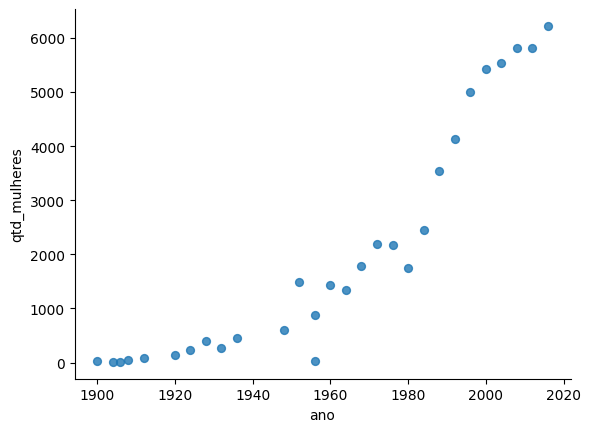

In [54]:
df.plot(kind='scatter', x='ano', y='qtd_mulheres', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### 4.2.3.3 - Query 2

In [55]:
# Define a consulta SQL
query = """select de.ano, de.con_sede, de.pais_sede,
count(fm.dim_atleta_id) qtd_homens,
round((count(fm.dim_atleta_id) - LAG(count(fm.dim_atleta_id)) OVER (ORDER BY ano)) / LAG(count(fm.dim_atleta_id)) OVER (ORDER BY ano) * 100,2) AS percentual_mudanca,
round((count(fm.dim_atleta_id) - FIRST_VALUE(count(fm.dim_atleta_id)) OVER (ORDER BY ano)) / FIRST_VALUE(count(fm.dim_atleta_id)) OVER (ORDER BY ano)* 100,2)  AS percentual_em_relacao_ao_primeiro
FROM `Olimpiadas.fato_medalhas` fm
JOIN `Olimpiadas.dim_atleta` da ON da.dim_atleta_id = fm.dim_atleta_id
JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
where da.sexo = 'M' and de.temporada = 'Summer'
group by de.ano, de.con_sede, de.pais_sede
order by de.ano
"""

# Executa a consulta e armazena os resultados em um dataframe
df = client.query(query).to_dataframe()

# Exibe os dados do dataframe
df

,ano,con_sede,pais_sede,qtd_homens,percentual_mudanca,percentual_em_relacao_ao_primeiro
0,1896,GRE,Greece,380,NaN,0.00
1,1900,FRA,France,1865,390.79,390.79
2,1904,USA,USA,1285,-31.10,238.16
3,1906,GRE,Greece,1722,34.01,353.16
4,1908,GBR,UK,3022,75.49,695.26
5,1912,SWE,Sweden,3953,30.81,940.26
6,1920,BEL,Belgium,4158,5.19,994.21
7,1924,FRA,France,4876,17.27,1183.16
8,1928,NED,Netherlands,4265,-12.53,1022.37
9,1932,USA,USA,2200,-48.42,478.95


#### 4.2.3.4 - Gráfico 2

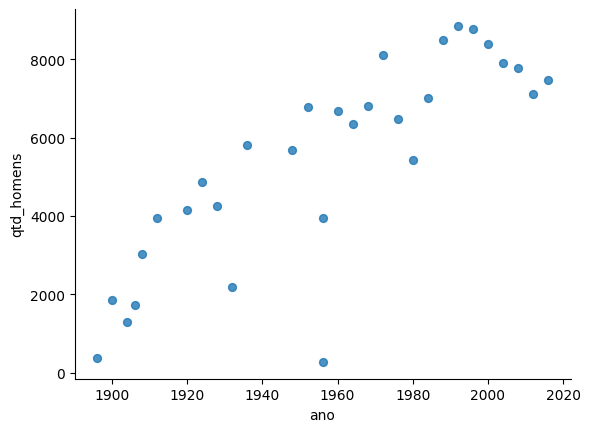

In [56]:
df.plot(kind='scatter', x='ano', y='qtd_homens', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### 4.2.3.5 - Query 3

In [57]:
# Define a consulta SQL
query = """WITH qtd_mulheres AS (
  SELECT
    de.ano,
    de.con_sede,
    de.pais_sede,
    COUNT(fm.dim_atleta_id) AS qtd_mulheres
  FROM `Olimpiadas.fato_medalhas` fm
  JOIN `Olimpiadas.dim_atleta` da ON da.dim_atleta_id = fm.dim_atleta_id
  JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
  WHERE da.sexo = 'F' AND de.temporada = 'Summer'
  GROUP BY de.ano, de.con_sede, de.pais_sede
),
qtd_homens AS (
  SELECT
    de.ano,
    de.con_sede,
    de.pais_sede,
    COUNT(fm.dim_atleta_id) AS qtd_homens
  FROM `Olimpiadas.fato_medalhas` fm
  JOIN `Olimpiadas.dim_atleta` da ON da.dim_atleta_id = fm.dim_atleta_id
  JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
  WHERE da.sexo = 'M' AND de.temporada = 'Summer'
  GROUP BY de.ano, de.con_sede, de.pais_sede
)
SELECT
  qh.ano,
  qh.con_sede,
  qh.pais_sede,
  ifnull(qtd_mulheres,0) qtd_mulheres,
  ifnull(qtd_homens,0) qtd_homens,
  round(ifnull(qtd_mulheres,0) / (ifnull(qtd_mulheres,0) + ifnull(qtd_homens,0)) * 100, 2) percentual_mulheres,
  round(ifnull(qtd_homens,0) / (ifnull(qtd_mulheres,0) + ifnull(qtd_homens,0)) * 100, 2) percentual_homens,
FROM qtd_mulheres qm
full outer join qtd_homens qh on qm.ano = qh.ano
ORDER BY ano;
"""

# Executa a consulta e armazena os resultados em um dataframe
df = client.query(query).to_dataframe()

# Exibe os dados do dataframe
df

,ano,con_sede,pais_sede,qtd_mulheres,qtd_homens,percentual_mulheres,percentual_homens
0,1896,GRE,Greece,0,380,0.00,100.00
1,1900,FRA,France,33,1865,1.74,98.26
2,1904,USA,USA,16,1285,1.23,98.77
3,1906,GRE,Greece,11,1722,0.63,99.37
4,1908,GBR,UK,47,3022,1.53,98.47
5,1912,SWE,Sweden,87,3953,2.15,97.85
6,1920,BEL,Belgium,134,4158,3.12,96.88
7,1924,FRA,France,234,4876,4.58,95.42
8,1928,NED,Netherlands,391,4265,8.40,91.60
9,1932,USA,USA,265,2200,10.75,89.25


#### 4.2.3.6 - Gráfico 3

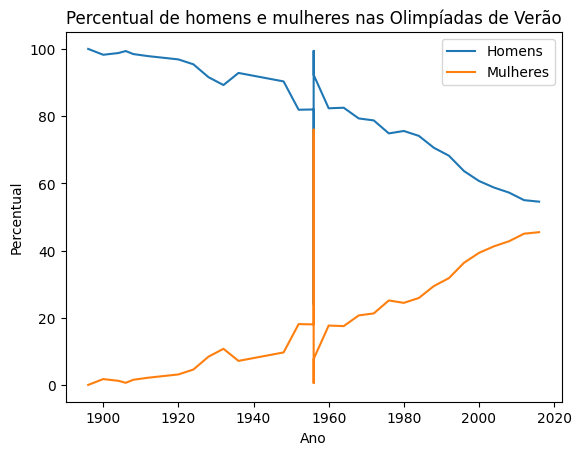

In [58]:
# Cria um gráfico de linhas com a percentagem de homens e mulheres
plt.plot(df['ano'], df['percentual_homens'], label='Homens')
plt.plot(df['ano'], df['percentual_mulheres'], label='Mulheres')

# Define os rótulos dos eixos x e y
plt.xlabel('Ano')
plt.ylabel('Percentual')

# Define o título do gráfico
plt.title('Percentual de homens e mulheres nas Olimpíadas de Verão')

# Adiciona uma legenda ao gráfico
plt.legend()

# Exibe o gráfico
plt.show()


#### 4.2.3.7 - Conclusão

**Explicação dos dados**

* Query 1 - Trago a evolução na quantidade de mulheres no decorrer das edições;
* Gráfico 1 - Ilustro a evolução na quantidade de mulheres;
* Query 2 - Trago a evolução na quantidade de homens no decorrer das edições;
* Gráfico 2 - Ilustro a evolução na quantidade de homens;
* Query 3 - Trago a porcentagem de homens e mulheres no decorrer das edições;
* Gráfico 3 - Ilustro a evolução na porcentagem de homens e mulheres;

**Conclusão**

A participação das mulheres nos Jogos Olímpicos tem aumentado significativamente ao longo das edições. Isso fica muito evidente no gráfico 3, que mostra a evolução da participação de homens e mulheres nas Olimpíadas de Verão.

Na primeira edição dos Jogos em 1896, a participação foi composta por 100% de homens. Nas primeiras 10 edições, a participação das mulheres não chegava a 10%. No entanto, a partir daí, a participação das mulheres começou a aumentar gradualmente.

Em 2016, a participação das mulheres chegou a 45%, quase se igualando ao número de homens. Isso mostra que as mulheres têm ganhado cada vez mais espaço nos Jogos Olímpicos, em uma tendência que provavelmente continuará nas próximas edições.

Isso nos leva à próxima pergunta:


### 4.2.4 - O número de participações femininas cresce igual para todos os países?

Nessa análise optei por verificar apenas os países que possuem um número considerável de atletas (50) e que a porcentagem de homens seja igual ou superior a 70%.

#### 4.2.4.1 - Query 1

In [59]:
# Define a consulta SQL
query = """WITH qtd_mulheres AS (
  SELECT
    de.ano,
    de.con_sede,
    de.pais_sede,
    dp.pais,
    COUNT(fm.dim_atleta_id) AS qtd_mulheres
  FROM `Olimpiadas.fato_medalhas` fm
  JOIN `Olimpiadas.dim_atleta` da ON da.dim_atleta_id = fm.dim_atleta_id
  JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
  JOIN `Olimpiadas.dim_participacao` dp ON dp.dim_participacao_id = fm.dim_participacao_id
  WHERE da.sexo = 'F' AND de.temporada = 'Summer'
  GROUP BY de.ano, de.con_sede, de.pais_sede, dp.pais
),
qtd_homens AS (
   SELECT
    de.ano,
    de.con_sede,
    de.pais_sede,
    dp.pais,
    COUNT(fm.dim_atleta_id) AS qtd_homens
  FROM `Olimpiadas.fato_medalhas` fm
  JOIN `Olimpiadas.dim_atleta` da ON da.dim_atleta_id = fm.dim_atleta_id
  JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
  JOIN `Olimpiadas.dim_participacao` dp ON dp.dim_participacao_id = fm.dim_participacao_id
  WHERE da.sexo = 'M' AND de.temporada = 'Summer'
  GROUP BY de.ano, de.con_sede, de.pais_sede, dp.pais
)
SELECT
  ifnull(qh.ano,qm.ano) ano,
  ifnull(qh.con_sede,qm.con_sede) con_sede,
  ifnull(qh.pais_sede,qm.pais_sede) pais_sede,
  ifnull(qh.pais,qm.pais) pais,
  ifnull(qtd_mulheres,0) qtd_mulheres,
  ifnull(qtd_homens,0) qtd_homens,
  round(ifnull(qtd_mulheres,0) / (ifnull(qtd_mulheres,0) + ifnull(qtd_homens,0)) * 100, 2) percent_mulheres,
  round(ifnull(qtd_homens,0) / (ifnull(qtd_mulheres,0) + ifnull(qtd_homens,0)) * 100, 2) percent_homens,
FROM qtd_mulheres qm
FULL OUTER JOIN qtd_homens qh ON qm.ano = qh.ano AND qm.pais = qh.pais
where (qtd_mulheres + qtd_homens) > 50
and round(ifnull(qtd_homens,0) / (ifnull(qtd_mulheres,0) + ifnull(qtd_homens,0)) * 100, 2) >= 70
ORDER BY qh.ano desc, qh.pais;
"""

# Executa a consulta e armazena os resultados em um dataframe
df = client.query(query).to_dataframe()

# Exibe os dados do dataframe
df.head(50)

,ano,con_sede,pais_sede,pais,qtd_mulheres,qtd_homens,percent_mulheres,percent_homens
0,2016,BRA,Brazil,Algeria,13,61,17.57,82.43
1,2016,BRA,Brazil,Azerbaijan,16,53,23.19,76.81
2,2016,BRA,Brazil,Croatia,24,69,25.81,74.19
3,2016,BRA,Brazil,Iran,11,56,16.42,83.58
4,2016,BRA,Brazil,Lithuania,20,60,25.00,75.00
5,2016,BRA,Brazil,South Africa,46,109,29.68,70.32
6,2016,BRA,Brazil,Venezuela,29,76,27.62,72.38
7,2012,GBR,UK,Azerbaijan,16,43,27.12,72.88
8,2012,GBR,UK,Iran,11,46,19.30,80.70
9,2012,GBR,UK,Morocco,19,48,28.36,71.64


#### 4.2.4.2 - Query 2

In [60]:
# Define a consulta SQL
query = """WITH qtd_mulheres AS (
  SELECT
    de.ano,
    de.con_sede,
    de.pais_sede,
    dp.pais,
    COUNT(fm.dim_atleta_id) AS qtd_mulheres
  FROM `Olimpiadas.fato_medalhas` fm
  JOIN `Olimpiadas.dim_atleta` da ON da.dim_atleta_id = fm.dim_atleta_id
  JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
  JOIN `Olimpiadas.dim_participacao` dp ON dp.dim_participacao_id = fm.dim_participacao_id
  WHERE da.sexo = 'F' AND de.temporada = 'Summer'
  GROUP BY de.ano, de.con_sede, de.pais_sede, dp.pais
),
qtd_homens AS (
   SELECT
    de.ano,
    de.con_sede,
    de.pais_sede,
    dp.pais,
    COUNT(fm.dim_atleta_id) AS qtd_homens
  FROM `Olimpiadas.fato_medalhas` fm
  JOIN `Olimpiadas.dim_atleta` da ON da.dim_atleta_id = fm.dim_atleta_id
  JOIN `Olimpiadas.dim_edicao` de ON de.dim_edicao_id = fm.dim_edicao_id
  JOIN `Olimpiadas.dim_participacao` dp ON dp.dim_participacao_id = fm.dim_participacao_id
  WHERE da.sexo = 'M' AND de.temporada = 'Summer'
  GROUP BY de.ano, de.con_sede, de.pais_sede, dp.pais
)
select ano, con_sede, pais_sede, count(pais) qtd_paises from
(
SELECT
  ifnull(qh.ano,qm.ano) ano,
  ifnull(qh.con_sede,qm.con_sede) con_sede,
  ifnull(qh.pais_sede,qm.pais_sede) pais_sede,
  ifnull(qh.pais,qm.pais) pais,
  ifnull(qtd_mulheres,0) qtd_mulheres,
  ifnull(qtd_homens,0) qtd_homens,
  round(ifnull(qtd_mulheres,0) / (ifnull(qtd_mulheres,0) + ifnull(qtd_homens,0)) * 100, 2) percent_mulheres,
  round(ifnull(qtd_homens,0) / (ifnull(qtd_mulheres,0) + ifnull(qtd_homens,0)) * 100, 2) percent_homens,
FROM qtd_mulheres qm
FULL OUTER JOIN qtd_homens qh ON qm.ano = qh.ano AND qm.pais = qh.pais
where (qtd_mulheres + qtd_homens) > 50
and round(ifnull(qtd_homens,0) / (ifnull(qtd_mulheres,0) + ifnull(qtd_homens,0)) * 100, 2) >= 70
) group by ano, con_sede, pais_sede
order by ano desc;
"""

# Executa a consulta e armazena os resultados em um dataframe
df = client.query(query).to_dataframe()

# Exibe os dados do dataframe
df

,ano,con_sede,pais_sede,qtd_paises
0,2016,BRA,Brazil,7
1,2012,GBR,UK,5
2,2008,CHN,China,8
3,2004,GRE,Greece,12
4,2000,AUS,Australia,14
5,1996,USA,USA,22
6,1992,ESP,Spain,20
7,1988,KOR,South Korea,24
8,1984,USA,USA,28
9,1980,RUS,Russia,19


#### 4.2.4.3 - Gráfico 1

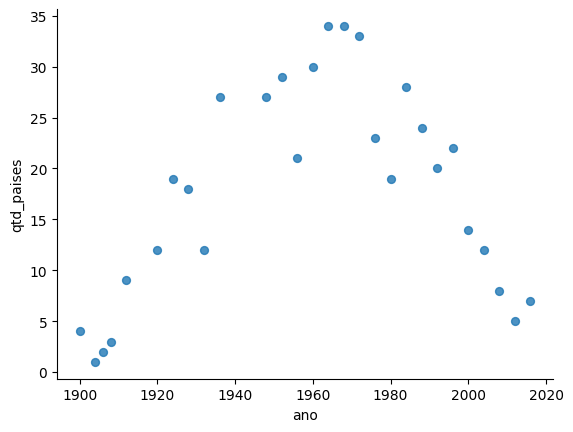

In [61]:
df.plot(kind='scatter', x='ano', y='qtd_paises', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### 4.2.4.4 - Conclusão

**Explicação dos dados**

* Query 1 - Trago os 50 registros das edições mais recentes da análise de países com pelo menos 50 atletas, onde 70% são do sexo masculino;
* Query 2 - Trago a evolução na quantidade desses países citados na Query 1 no decorrer das edições;
* Gráfico 1 - Ilustro a evolução citada na Query 2. Antes de 1980 poucos países possuíam mais do que 50 atletas, o que gerou essa distorção no gráfico.

**Conclusão**

A participação das mulheres nos Jogos Olímpicos tem aumentado conforme vimos no item 5.2.3.7, mas podemos notar que alguns países ainda vão contra essa tendência global.

Notamos que nessa lista estão pouquíssimos países de primeiro mundo, e os que estão, podemos notar que não estão presentes nessa situação por 2 edições seguidas, o que nos leva a crer que podem ter sido casos atípicos de atletas que femininos que não conseguiram se classificar. Nessa situação podemos verificar países como Suíça, Dinamarca, Noruega, e Bélgica.

Na grande maioria dessa lista, podemos verificar países de segundo ou terceiro mundo, que podem estar relacionados a falta de investimento no esporte feminino, ou até mesmo falta de investimento no esporte como um todo. Nessa situação podemos verificar países como Argélia, Azerbaijão, Venezuela, Uzbequistão e Quirguistão.
<br> Ou até mesmo por motivos religiosos e culturais, em países onde o sexo feminino possui menor representatividade. Nessa situação podemos verificar países como Irã, Marrocos, Egito e Israel.

No entanto, essa situação tem se tornado cada vez menos frequente, como podemos observar no gráfico 2, que mostra a diminuição do número de países que se enquadram nessa categoria.

Embora os dados não possam explicar o motivo dessas diferenças, eles chamam a atenção para locais que necessitam de maior atenção e investimento no esporte feminino.

# 5 - Autoavaliação

Em relação aos objetivos propostos, consegui criar uma estrutura atendendo os requisitos do projeto e consegui resolver as perguntas que foram propostas, o que me faz acreditar que atingi o que havia planejado inicialmente. No entanto, durante a execução do trabalho, enfrentei algumas dificuldades.

Uma das maiores dificuldades foi a utilização da versão gratuita do Databricks, que apresentou algumas limitações para o processamento dos dados. Para contornar esse problema, optei por utilizar o Google Colab em conjunto com o Big Query do GCP, o que me permitiu realizar as análises de forma mais eficiente.

Para enriquecer esse trabalho, poderia ser implementado um ETL incremental que possa trazer os dados das novas Olimpíadas, automatizando assim o processo de atualização dos dados. Além de um processo de atualização das medalhas de atletas que perderam sua medalhas por motivos diversos (geralmente por comprovação de doping).

No geral, estou satisfeito com os resultados obtidos e acredito que esse trabalho foi uma boa oportunidade para aprofundar meus conhecimentos em análise e estruturação de dados.